In [1]:
import os
import astropy.io.fits as fits
import numpy as np
import scipy
import scipy.ndimage as ndi
import matplotlib.pylab as plt
import pyklip.klip
import pyklip.instruments.Instrument as Instrument
import pyklip.parallelized as parallelized
import pyklip.rdi as rdi
import pyklip.fakes as fakes
import glob
from astropy.table import Table
from astropy.table import join
from astropy.table import vstack
import seaborn as sbn
import pandas as pd
import pdb

/Users/jeaadams/pyklip/pyklip/klip.py:47: RuntimeWarning: Mean of empty slice
  return np.nanmean(data, axis=axis)
/Users/jeaadams/pyklip/pyklip/klip.py:47: RuntimeWarning: Mean of empty slice
  return np.nanmean(data, axis=axis)
/Users/jeaadams/pyklip/pyklip/klip.py:47: RuntimeWarning: Mean of empty slice
  return np.nanmean(data, axis=axis)
/Users/jeaadams/pyklip/pyklip/klip.py:47: RuntimeWarning: Mean of empty slice
  return np.nanmean(data, axis=axis)
/Users/jeaadams/pyklip/pyklip/klip.py:47: RuntimeWarning: Mean of empty slice
  return np.nanmean(data, axis=axis)
/Users/jeaadams/pyklip/pyklip/klip.py:47: RuntimeWarning: Mean of empty slice
  return np.nanmean(data, axis=axis)
/Users/jeaadams/pyklip/pyklip/klip.py:47: RuntimeWarning: Mean of empty slice
  return np.nanmean(data, axis=axis)
/Users/jeaadams/pyklip/pyklip/klip.py:47: RuntimeWarning: Mean of empty slice
  return np.nanmean(data, axis=axis)
/Users/jeaadams/pyklip/pyklip/klip.py:47: RuntimeWarning: Mean of empty slice
  

/Users/jeaadams/pyklip/pyklip/klip.py:47: RuntimeWarning: Mean of empty slice
  return np.nanmean(data, axis=axis)
/Users/jeaadams/pyklip/pyklip/klip.py:47: RuntimeWarning: Mean of empty slice
  return np.nanmean(data, axis=axis)
/Users/jeaadams/pyklip/pyklip/klip.py:47: RuntimeWarning: Mean of empty slice
  return np.nanmean(data, axis=axis)
/Users/jeaadams/pyklip/pyklip/klip.py:47: RuntimeWarning: Mean of empty slice
  return np.nanmean(data, axis=axis)
/Users/jeaadams/pyklip/pyklip/klip.py:47: RuntimeWarning: Mean of empty slice
  return np.nanmean(data, axis=axis)
/Users/jeaadams/pyklip/pyklip/klip.py:47: RuntimeWarning: Mean of empty slice
  return np.nanmean(data, axis=axis)
/Users/jeaadams/pyklip/pyklip/klip.py:47: RuntimeWarning: Mean of empty slice
  return np.nanmean(data, axis=axis)
/Users/jeaadams/pyklip/pyklip/klip.py:47: RuntimeWarning: Mean of empty slice
  return np.nanmean(data, axis=axis)
/Users/jeaadams/pyklip/pyklip/klip.py:47: RuntimeWarning: Mean of empty slice
  

/Users/jeaadams/pyklip/pyklip/klip.py:47: RuntimeWarning: Mean of empty slice
  return np.nanmean(data, axis=axis)
/Users/jeaadams/pyklip/pyklip/klip.py:47: RuntimeWarning: Mean of empty slice
  return np.nanmean(data, axis=axis)
/Users/jeaadams/pyklip/pyklip/klip.py:47: RuntimeWarning: Mean of empty slice
  return np.nanmean(data, axis=axis)
/Users/jeaadams/pyklip/pyklip/klip.py:47: RuntimeWarning: Mean of empty slice
  return np.nanmean(data, axis=axis)
/Users/jeaadams/pyklip/pyklip/klip.py:47: RuntimeWarning: Mean of empty slice
  return np.nanmean(data, axis=axis)
/Users/jeaadams/pyklip/pyklip/klip.py:47: RuntimeWarning: Mean of empty slice
  return np.nanmean(data, axis=axis)
/Users/jeaadams/pyklip/pyklip/klip.py:47: RuntimeWarning: Mean of empty slice
  return np.nanmean(data, axis=axis)
/Users/jeaadams/pyklip/pyklip/klip.py:47: RuntimeWarning: Mean of empty slice
  return np.nanmean(data, axis=axis)
/Users/jeaadams/pyklip/pyklip/klip.py:47: RuntimeWarning: Mean of empty slice
  

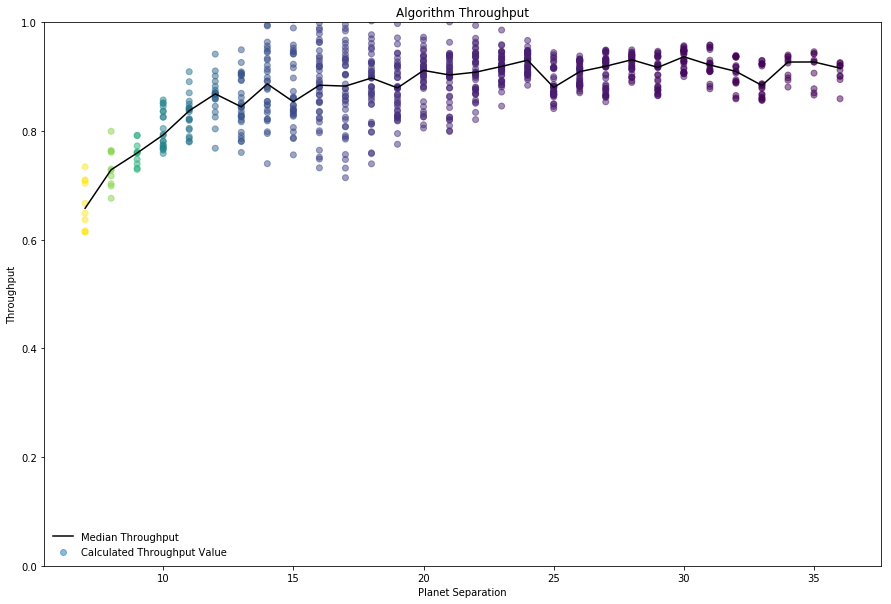

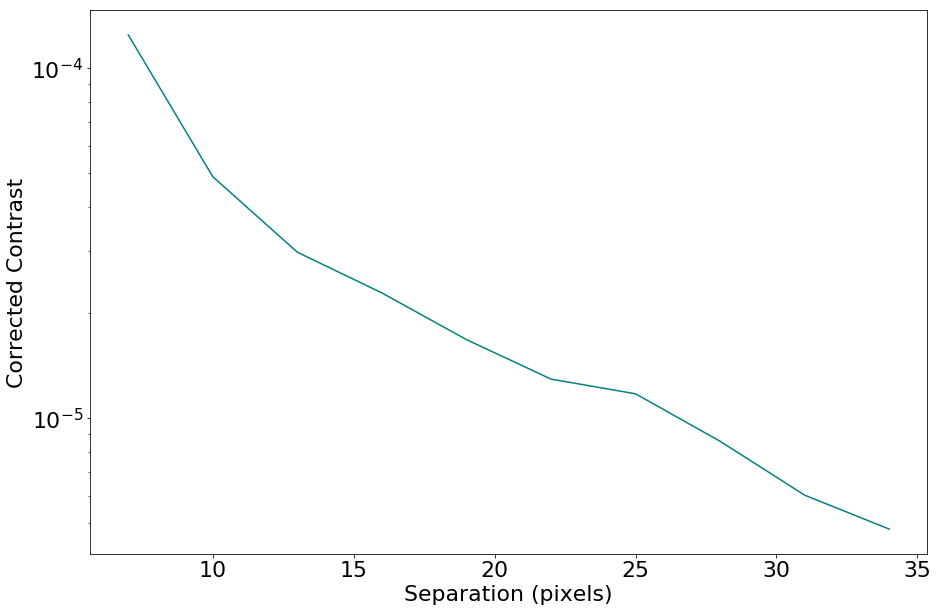

In [2]:
parent_directory = '.'
filtername = "f300m"


# read in unocculted PSF
with fits.open(parent_directory + "/old_simulated_data/NIRCam_unocculted_{0}.fits".format(filtername)) as hdulist:
    psf_cube = hdulist[0].data 
    psf_head = hdulist[0].header
    
# collapse reference psf in time
psf_frame = np.nanmean(psf_cube, axis=0)

# find the centroid
bestfit = fakes.gaussfit2d(psf_frame, 71, 30, searchrad=3, guessfwhm=2, guesspeak=1, refinefit=True)

psf_xcen, psf_ycen = bestfit[2:4]

# recenter PSF to that location
x, y = np.meshgrid(np.arange(-20,20.1,1), np.arange(-20,20.1,1))
x += psf_xcen
y += psf_ycen

psf_stamp = scipy.ndimage.map_coordinates(psf_frame, [y,x])



def generate_datasets(num_datasets):
    """
    Generates multiple generic datasets based on the two JWST roll angles 0" and 10"
    
    Args:
        num_datasets(int): Number of datasets to be generated
    
    Returns:
        datasets(list): List of generated datasets
    """
    datasets = []
    for dataset in range(num_datasets):

        #Import the dataset to be used
        filtername = "f300m"

        # read in roll 1
        with fits.open(parent_directory + "/old_simulated_data/NIRCam_target_Roll1_{0}.fits".format(filtername)) as hdulist:
            roll1_cube = hdulist[0].data

        # read in roll 2
        with fits.open(parent_directory + "/old_simulated_data/NIRCam_target_Roll2_{0}.fits".format(filtername)) as hdulist:
            roll2_cube = hdulist[0].data  

        # combine the two rows
        full_seq = np.concatenate([roll1_cube, roll2_cube], axis=0)

        # two rolls are offset 10 degrees
        pas = np.append([0 for _ in range(roll1_cube.shape[0])], [10 for _ in range(roll2_cube.shape[0])])

        # for each image, the (x,y) center where the star is is just the center of the image
        centers = np.array([np.array(frame.shape)//2. for frame in full_seq])

        # give it some names, just in case we want to refer to them
        filenames = np.append(["roll1_{0}".format(i) for i in range(roll1_cube.shape[0])],
                              ["roll2_{0}".format(i) for i in range(roll1_cube.shape[0])])

        #Define dataset
        dataset = Instrument.GenericData(full_seq, centers, IWA=4, parangs=pas, filenames=filenames)
        dataset.flipx = False
        datasets.append(dataset)
        
    return datasets


#Mask the 1st planet

  
planet1_peak_x = 41 
planet1_peak_y = 54

planet2_peak_x = 43
planet2_peak_y = 70

contrasts = Table.read((parent_directory+'/contrast.csv'))
mask210 = pd.read_csv(parent_directory+"/MASK210R.csv")

def transmission_corrected(input_stamp, input_dx, input_dy):
    distance_from_center = np.sqrt((input_dx)**2+(input_dy)**2)
    trans_at_dist = np.interp(distance_from_center, np.array(mask210["rad_dist"]),
                                     np.array(mask210["trans"]))
    transmission_stamp = trans_at_dist.reshape(input_stamp.shape)
    output_stamp = transmission_stamp*input_stamp
    return output_stamp

    
def multiple_planet_injection(nplanets, dist_bt_planets, min_sep, max_sep, pas, pas_step_size, num_datasets):
    """
    Injects multiple fake planets across multiple datasets, changing the position angle of injection each time. 
    
    Args:
        nplanets(int): The number of planets to be injected per KLIP reduction (should be equal to the size of input_contrasts list)
        min_sep(int): The minimum planet separation from the host star
        max_sep(int): The maximum planet separation from the host star
        dist_bt_planets(int): The distance between each injected planet in the same image 
        pas (float): List of position angles to inject fake planets at during first iteration
        pas_step_size(float): Amount by which position angles should be increased during each iteration
        sep_step_size(float): Amount by which separation from star should be increased during each iteration
        num_datastes(int): The number of datasets to be generated. This is equal to the number of interations of planet injection/number of position angle changes
        input_contrasts(float): List of contrasts planets should be injected at
    Returns:
        retrieved_values(pandas table): Table of values retrieved for retrieved_flux and throughput at each pa and separation. 
    """
    
    pas_all = [] 
    retrieved_fluxes_all = []
    planet_seps_all = [] 
    input_contrasts_all = []

    #maximum separation in first iteration
    max_sep_1 = min_sep+dist_bt_planets*nplanets

    #number of times to iterate to get to max desired separation (max desired sep - max sep in first iteration)
    n_sep_loops = max_sep - max_sep_1



    for n in range(n_sep_loops):
        seps = np.arange(min_sep+n, max_sep_1+n, dist_bt_planets)
        input_contrasts = np.interp(seps, contrasts['separation'], contrasts['above_contrast'])

    


        
        #generate desired number of datasets
        datasets = generate_datasets(num_datasets)

        _seps_pas = []
        _seps_retrieved_fluxes = []
        _seps_planet_seps = []
        _seps_input_contrasts = []

        pas_all.append(_seps_pas)
        retrieved_fluxes_all.append(_seps_retrieved_fluxes)
        planet_seps_all.append(_seps_planet_seps)
        input_contrasts_all.append(_seps_input_contrasts)


        
        #begin fake planets injection and retrieval, changing pa each time
        for dataset_num, dataset in enumerate(datasets):
            
            #Create stamps of the point spread function to be injected as a fake planet
            psf_stamp_input = np.array([psf_stamp for j in range(12)])
            
            #Create an array of the position angles planets should be injected at, accounting for the roll angles
            pas_array = [x+pas_step_size*dataset_num for x in pas]
            planet_seps = seps

            
            
            start_over = False
            
            
            #Inject fake planets
            for input_contrast, planet_sep, pa in zip(input_contrasts, planet_seps, pas_array):
                
                # Check the distance between the planet to be injected and the planets already in the data. We don't want to inject fake planets too close to the two planets already in the data.
                check_sep_x = planet_sep*np.cos((pa + 90)) 
                check_sep_y = planet_sep*np.sin((pa + 90))
                dist_p1 = np.sqrt((check_sep_x - planet1_peak_x)**2 + (check_sep_y - planet1_peak_y)**2)
                dist_p2 = np.sqrt((check_sep_x - planet2_peak_x)**2 + (check_sep_y - planet2_peak_y)**2)
                
                #Make sure fake planets won't be injected within a 12 pixel radius of the real planets
                if dist_p1 > 12 and dist_p2 > 12:
                    planet_fluxes = psf_stamp_input*input_contrast


                    fakes.inject_planet(frames = dataset.input, 
                                        centers=dataset.centers, 
                                        inputflux=planet_fluxes, 
                                        astr_hdrs=dataset.wcs, 
                                        radius=planet_sep,
                                        pa = pa,
                                        field_dependent_correction = transmission_corrected)
                
                #If the fake planet to be injected is within a 12 pixel radius of the real planets, start over the loop
                else:
                    start_over = True
                    
            if start_over:
                continue
                
            ######################################################################################################
            
            #Run KLIP on datasets with injected planets
            
            
            #Set output directory
            outputdir = parent_directory + "/contrastcurves"
            fileprefix = "FAKE_KLIP_ADI_A9K5S4M1_" + str(dataset_num)+ str(n_sep_loops)
            filename = "FAKE_KLIP_ADI_A9K5S4M1_" + str(dataset_num) +str(n_sep_loops) + "-KLmodes-all.fits"
            numbasis = [1,5,10,20,50]


            #Run KLIP on dataset with injected fakes
            parallelized.klip_dataset(dataset, 
                                    outputdir=outputdir, 
                                    fileprefix=fileprefix, 
                                    algo = 'klip', 
                                    annuli=1, 
                                    subsections=1, 
                                    movement=1, 
                                    numbasis=numbasis, 
                                    mode="ADI",
                                    verbose = False)
            
            ######################################################################################################
            
            #Retireve fake planet fluxes from the KLIP-ed dataset
            
            
            #Open one frame of the KLIP-ed dataset
            klipdataset = os.path.join(outputdir,filename)
            with fits.open(klipdataset) as hdulist:
                outputfile = hdulist[0].data
                outputfile_centers = [hdulist[0].header['PSFCENTX'], hdulist[0].header['PSFCENTY']]
            outputfile_frame = outputfile[2]

            
            
            retrieved_planet_fluxes = []
            
            #Retrieve planet flux function
            for input_contrast, planet_sep, pa in zip(input_contrasts, planet_seps, pas_array):

                fake_flux = fakes.retrieve_planet_flux(frames = outputfile_frame, 
                                                        centers=outputfile_centers,
                                                        astr_hdrs=dataset.output_wcs[0], 
                                                        sep=planet_sep,
                                                        pa = pa,
                                                        searchrad = 7)

                retrieved_planet_fluxes.append(fake_flux)
                
            
            _seps_retrieved_fluxes.append(retrieved_planet_fluxes)
            _seps_pas.append(pas)
            _seps_planet_seps.append(planet_seps)
            _seps_input_contrasts.append(input_contrasts)
            
        ######################################################################################################
        
    #Creating output table
    retrieved_fluxes_all = np.array(retrieved_fluxes_all).ravel()
    pas_all = np.array(pas_all).ravel()
    planet_seps_all = np.array(planet_seps_all).ravel()
    input_contrasts_all = np.array(input_contrasts_all).ravel()


    #Loop through each list to create a table of all variables
    
    flux_sep = Table([retrieved_fluxes_all,planet_seps_all, input_contrasts_all, pas_all], names = ('flux', 'separation', 'input_contrast', 'pas'))
    flux_sep['input_flux'] = flux_sep['input_contrast']*bestfit[0]
    #Calculate throughput and add it to list 
    flux_sep['throughput'] = flux_sep['flux']/flux_sep['input_flux']

    #We can also calculate the median througput per separation

    #Group by separation
    flux_by_sep = flux_sep.group_by('separation')

    #Calculate the median value for each separation group
    med_flux_by_sep = flux_by_sep.groups.aggregate(np.median)

        
        
    return flux_sep, med_flux_by_sep

output_table_all, output_table_bysep = multiple_planet_injection(
          dist_bt_planets = 3,
          min_sep = 7,
          max_sep = 40,
          nplanets = 4,
          pas = [0, 30, 60, 120], 
          pas_step_size = 75,
          num_datasets = 10)
 


plt.figure(figsize = (15,10))
plt.plot(output_table_bysep["separation"],output_table_bysep["throughput"],  color = 'black', label = 'Median Throughput')
plt.scatter(output_table_all["separation"], output_table_all["throughput"], c = output_table_all['input_contrast'], label = "Calculated Throughput Value", alpha = 0.5)
plt.ylabel("Throughput")
plt.xlabel("Planet Separation")
plt.title("Algorithm Throughput")
plt.ylim(0,1)
plt.legend(frameon = False, loc = 'lower left')
plt.rcParams.update({'font.size': 22})




corrected_contrast = join(output_table_bysep, contrasts)
#Normalize the noise contrast by the measured throughput level at that separation
corrected_contrast['corrected_contrast']=corrected_contrast['contrast']/corrected_contrast['throughput']


plt.figure(figsize = (15,10))
plt.plot(corrected_contrast['separation'], corrected_contrast['corrected_contrast'], color = 'teal')
plt.rcParams.update({'font.size': 20})
plt.ylabel('Corrected Contrast')
plt.xlabel('Separation (pixels)')
plt.yscale('log')
plt.rcParams.update({'font.size': 22})
plt.show()